```{index} single: application; transportation
```
```{index} single: solver; HiGHS
```
```{index} pandas dataframe
```
```{index} network optimization
```
```{index} single: Pyomo; display
```
```{index} single: Pyomo; Suffix
```
```{index} single: Pyomo; dual variables
```

# 4.3 Gasoline distribution
   
This notebook presents a transportation model to optimally allocate the delivery of a commodity from multiple sources to multiple destinations. The model invites a discussion of the pitfalls in optimizing a global objective for customers who may have an uneven share of the resulting benefits, then through model refinement arrives at a group cost-sharing plan to delivery costs.

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [1]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

Didactically, this notebook presents techniques for Pyomo modeling and reporting including:

* `pyo.Expression` decorator
* Accessing the duals (i.e., shadow prices)
* Methods for reporting the solution and duals.
    * Pyomo `.display()` method for Pyomo objects
    * Manually formatted reports
    * Pandas
    * Graphviz for display of results as a directed graph.

## Problem: Distributing gasoline to franchise operators

YaYa Gas-n-Grub is the franchisor and operator of a network of regional convenience stores that sell gasoline and convenience items in the United States. Each store is individually owned by a YaYa Gas-n-Grub franchisee who pays fees to the franchisor for services. Gasoline is delivered by truck from regional distribution terminals by the current supplier. Each truck delivers 8,000 gallons at a fixed charge of \$700 per delivery or \$0.0875 per gallon. Franchise owners are eager to reduce delivery costs to boost profits.

YaYa Gas-n-Grub decides to accept proposals from other distribution terminals, "A" and "B", to supply the franchise operators. Rather than a fixed fee per delivery, they proposed pricing based on location. But they already have existing customers, "A" and "B" can only provide a limited amount of gasoline to new customers totaling 100,000 and 80,000 gallons respectively. The only difference between the new suppliers and the current supplier is the delivery charge.

The following chart shows the pricing of gasoline delivery in cents/gallon.

<div align="center">

| Franchisee <br> &nbsp; | Demand <br> &nbsp; | Current Supplier <br> 500,000 |  Terminal A <br> 100,000| Terminal B <br> 80,000 |
| :-------- | ------------: | :--------: | :---------: | :-------: |
| Alice | 30,000 | 8.75 | 8.3 | 10.2 |
| Badri  | 40,000 | 8.75 | 8.1 | 12.0 |
| Cara  | 50,000 | 8.75 | 8.3 | - |
| Dan   | 80,000 | 8.75 | 9.3 | 8.0 |
| Emma  | 30,000 | 8.75 | 10.1 | 10.0 |
| Fujita | 45,000 | 8.75 | 9.8 | 10.0 |
| Grace | 80,000 | 8.75 | -  | 8.0 |
| Helen | 18,000 | 8.75 | 7.5 | 10.0 |
| **TOTAL**| **313,000**| |  | | |


</div>

The operator of YaYa Gas-n-Grub wants to allocate gasoline delivery in such a way that the costs to franchise owners are minimized.

## Model 1: Minimize total delivery cost

The first optimization model aims to minimize the total cost of delivery to all franchise owners.

We introduce the decision variables $x_{d, s} \geq 0$, where subscript $d \in 1, \dots, n_d$ refers to the destination of the delivery and subscript $s \in 1, \dots, n_s$ to the source. The value of $x_{d,s}$ is the volume of gasoline shipped to destination $d$ from source $s$.

Given the cost rate $r_{d, s}$ for delivering one unit of gasoline from $d$ to $s$, the objective is to minimize the total cost of transporting gasoline from the sources to the destinations subject to meeting the demand requirements, $D_d$, at all destinations, and satisfying the supply constraints, $S_s$, at all sources.

In mathematical terms, we can write the full problem as

$$
\begin{align*}
    \min \quad & \sum_{d=1}^{n_d} \sum_{s=1}^{n_s} r_{d, s} x_{d, s} \\
    \text{s.t.} \quad &\sum_{s=1}^{n_s} x_{d, s}  = D_d & \forall \, d = 1, \dots, n_d & \quad \text{(demand constraints)}\\
    & \sum_{d=1}^{n_d} x_{d, s}  \leq S_s & \forall \, s = 1, \dots, n_s & \quad \text{(supply constraints)}\\
    & x_{d, s} \geq 0 & \forall \, d = 1, \dots, n_d, \, s = 1, \dots, n_s.
\end{align*}
$$


## Data Entry

The data is stored into Pandas DataFrame and Series objects. Note the use of a large rates to avoid assigning shipments to destination-source pairs not allowed by the problem statement.

In [2]:
import pandas as pd
from IPython.display import HTML, display
import matplotlib.pyplot as plt

rates = pd.DataFrame(
    [
        ["Alice", 8.3, 10.2, 8.75],
        ["Badri", 8.1, 12.0, 8.75],
        ["Cara", 8.3, 100.0, 8.75],
        ["Dan", 9.3, 8.0, 8.75],
        ["Emma", 10.1, 10.0, 8.75],
        ["Fujita", 9.8, 10.0, 8.75],
        ["Grace", 100, 8.0, 8.75],
        ["Helen", 7.5, 10.0, 8.75],
    ],
    columns=["Destination", "Terminal A", "Terminal B", "Current Supplier"],
).set_index("Destination")

demand = pd.Series(
    {
        "Alice": 30000,
        "Badri": 40000,
        "Cara": 50000,
        "Dan": 20000,
        "Emma": 30000,
        "Fujita": 45000,
        "Grace": 80000,
        "Helen": 18000,
    },
    name="demand",
)

supply = pd.Series(
    {"Terminal A": 100000, "Terminal B": 80000, "Current Supplier": 500000},
    name="supply",
)

display(HTML("<br><b>Gasoline Supply (Gallons)</b>"))
display(supply.to_frame())

display(HTML("<br><b>Gasoline Demand (Gallons)</b>"))
display(demand.to_frame())

display(HTML("<br><b>Transportation Rates ($ cents per Gallon)</b>"))
display(rates)

,supply
Terminal A,100000
Terminal B,80000
Current Supplier,500000


,demand
Alice,30000
Badri,40000
Cara,50000
Dan,20000
Emma,30000
Fujita,45000
Grace,80000
Helen,18000


,Terminal A,Terminal B,Current Supplier
Destination,,,
Alice,8.3,10.2,8.75
Badri,8.1,12.0,8.75
Cara,8.3,100.0,8.75
Dan,9.3,8.0,8.75
Emma,10.1,10.0,8.75
Fujita,9.8,10.0,8.75
Grace,100.0,8.0,8.75
Helen,7.5,10.0,8.75


The following Pyomo model is an implementation of the mathematical optimization model described above. The sets and indices have been designated with more descriptive symbols readability and maintenance.

Old delivery costs = $27387.50
New delivery costs = $26113.50



,Terminal A,Terminal B,Current Supplier,current costs,contract costs,savings,contract rate,marginal cost
Alice,0,0,30000,2625.0,2625.0,0.0,8.75,8.75
Badri,40000,0,0,3500.0,3240.0,260.0,8.10,8.55
Cara,42000,0,8000,4375.0,4186.0,189.0,8.37,8.75
Dan,0,0,20000,1750.0,1750.0,0.0,8.75,8.75
Emma,0,0,30000,2625.0,2625.0,0.0,8.75,8.75
Fujita,0,0,45000,3937.5,3937.5,0.0,8.75,8.75
Grace,0,80000,0,7000.0,6400.0,600.0,8.00,8.75
Helen,18000,0,0,1575.0,1350.0,225.0,7.50,7.95


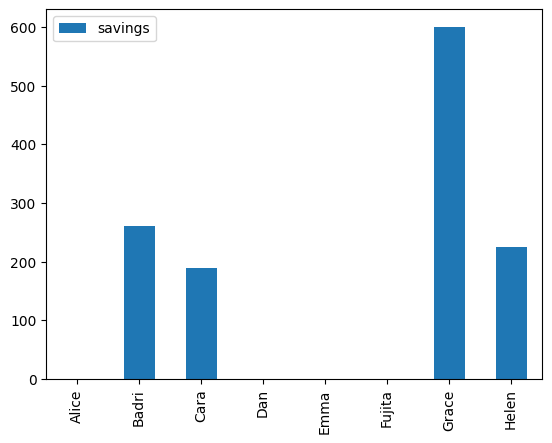

In [3]:
def transport(supply, demand, rates):
    m = pyo.ConcreteModel("Gasoline distribution")

    m.SOURCES = pyo.Set(initialize=rates.columns)
    m.DESTINATIONS = pyo.Set(initialize=rates.index)

    m.x = pyo.Var(m.DESTINATIONS, m.SOURCES, domain=pyo.NonNegativeReals)

    @m.Param(m.DESTINATIONS, m.SOURCES)
    def Rates(m, dst, src):
        return rates.loc[dst, src]

    @m.Objective(sense=pyo.minimize)
    def total_cost(m):
        return sum(
            m.Rates[dst, src] * m.x[dst, src] for dst, src in m.DESTINATIONS * m.SOURCES
        )

    @m.Expression(m.DESTINATIONS)
    def cost_to_destination(m, dst):
        return sum(m.Rates[dst, src] * m.x[dst, src] for src in m.SOURCES)

    @m.Expression(m.DESTINATIONS)
    def shipped_to_destination(m, dst):
        return sum(m.x[dst, src] for src in m.SOURCES)

    @m.Expression(m.SOURCES)
    def shipped_from_source(m, src):
        return sum(m.x[dst, src] for dst in m.DESTINATIONS)

    @m.Constraint(m.SOURCES)
    def supply_constraint(m, src):
        return m.shipped_from_source[src] <= supply[src]

    @m.Constraint(m.DESTINATIONS)
    def demand_constraint(m, dst):
        return m.shipped_to_destination[dst] == demand[dst]

    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    return m


m = transport(supply, demand, rates / 100)
SOLVER.solve(m)
results = pd.DataFrame(
    {dst: {src: round(m.x[dst, src]()) for src in m.SOURCES} for dst in m.DESTINATIONS}
).T
results["current costs"] = 700 * demand / 8000
results["contract costs"] = pd.Series(
    {dst: m.cost_to_destination[dst]() for dst in m.DESTINATIONS}
)
results["savings"] = results["current costs"].round(1) - results[
    "contract costs"
].round(1)
results["contract rate"] = 100 * round(results["contract costs"] / demand, 4)
results["marginal cost"] = 100 * pd.Series(
    {dst: m.dual[m.demand_constraint[dst]] for dst in m.DESTINATIONS}
)

print(f"Old delivery costs = ${sum(demand)*700/8000:.2f}")
print(f"New delivery costs = ${m.total_cost():.2f}\n")
display(results)

results.plot(y="savings", kind="bar")
model1_results = results

## Model 2: Minimize cost rate for franchise owners

Minimizing total costs provides no guarantee that individual franchise owners will benefit equally, or in fact benefit at all, from minimizing total costs. In this example neither Emma or Fujita would save any money on delivery costs, and the majority of savings goes to just one of the franchisees. Without a better distribution of the benefits there may be little enthusiasm among the franchisees to adopt change. This observation motivates an attempt at a second model. In this case the objective is minimizing a common rate for the cost of gasoline distribution subject to meeting the demand and supply constraints, $S_s$, at all sources.

The mathematical formulation of this different problem is as follows:

$$
\begin{align*}
    \min \quad & \rho \\
    \text{s.t.} \quad &\sum_{s=1}^{n_s} x_{d, s}  = D_d & \forall \, d = 1, \dots, n_d & \quad \text{(demand constraints)}\\
    & \sum_{d=1}^{n_d} x_{d, s}  \leq S_s & \forall \, s =  1, \dots, n_s & \quad \text{(supply constraints)}\\
    & \sum_{s=1}^{n_s} r_{d, s} x_{d, s} \leq \rho D_d & \forall d = 1, \dots, n_d & \quad \text{(common cost rate)}\\
    & x_{d, s} \geq 0 & \forall \, d = 1, \dots, n_d, \, s = 1, \dots, n_s.
\end{align*}
$$

The following Pyomo model implements this formulation.

Old delivery costs = $27387.5
New delivery costs = $27387.5


,Terminal A,Terminal B,Current Supplier,current costs,contract costs,savings,contract rate,marginal cost
Alice,22894.7,7105.3,0.0,2625.0,2625.0,0.0,8.75,-0.0
Badri,0.0,0.0,40000.0,3500.0,3500.0,0.0,8.75,-0.0
Cara,0.0,0.0,50000.0,4375.0,4375.0,0.0,8.75,-0.0
Dan,11538.5,8461.5,0.0,1750.0,1750.0,0.0,8.75,-0.0
Emma,0.0,0.0,30000.0,2625.0,2625.0,0.0,8.75,-0.0
Fujita,0.0,0.0,45000.0,3937.5,3937.5,0.0,8.75,0.0
Grace,455.6,55433.2,24111.2,7000.0,7000.0,0.0,8.75,-0.0
Helen,9000.0,9000.0,0.0,1575.0,1575.0,0.0,8.75,-0.0


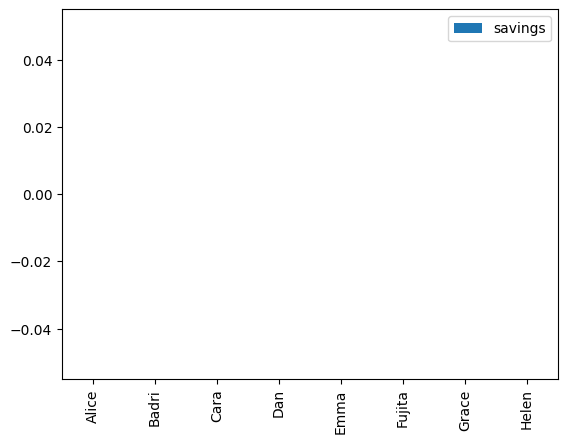

In [4]:
def transport_v2(supply, demand, rates):
    m = pyo.ConcreteModel()

    m.SOURCES = pyo.Set(initialize=rates.columns)
    m.DESTINATIONS = pyo.Set(initialize=rates.index)

    m.x = pyo.Var(m.DESTINATIONS, m.SOURCES, domain=pyo.NonNegativeReals)
    m.rate = pyo.Var()

    @m.Param(m.DESTINATIONS, m.SOURCES)
    def Rates(m, dst, src):
        return rates.loc[dst, src]

    @m.Objective(sense=pyo.minimize)
    def delivery_rate(m):
        return m.rate

    @m.Expression(m.DESTINATIONS)
    def cost_to_destination(m, dst):
        return sum(m.Rates[dst, src] * m.x[dst, src] for src in m.SOURCES)

    @m.Expression()
    def total_cost(m):
        return sum(m.cost_to_destination[dst] for dst in m.DESTINATIONS)

    @m.Constraint(m.DESTINATIONS)
    def rate_to_destination(m, dst):
        return m.cost_to_destination[dst] == m.rate * demand[dst]

    @m.Expression(m.DESTINATIONS)
    def shipped_to_destination(m, dst):
        return sum(m.x[dst, src] for src in m.SOURCES)

    @m.Expression(m.SOURCES)
    def shipped_from_source(m, src):
        return sum(m.x[dst, src] for dst in m.DESTINATIONS)

    @m.Constraint(m.SOURCES)
    def supply_constraint(m, src):
        return m.shipped_from_source[src] <= supply[src]

    @m.Constraint(m.DESTINATIONS)
    def demand_constraint(m, dst):
        return m.shipped_to_destination[dst] == demand[dst]

    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    return m


m = transport_v2(supply, demand, rates / 100)
SOLVER.solve(m)
results = round(
    pd.DataFrame(
        {dst: {src: m.x[dst, src]() for src in m.SOURCES} for dst in m.DESTINATIONS}
    ).T,
    1,
)
results["current costs"] = 700 * demand / 8000
results["contract costs"] = round(
    pd.Series({dst: m.cost_to_destination[dst]() for dst in m.DESTINATIONS}), 1
)
results["savings"] = results["current costs"].round(1) - results[
    "contract costs"
].round(1)
results["contract rate"] = 100 * round(results["contract costs"] / demand, 4)
results["marginal cost"] = 100 * pd.Series(
    {dst: round(m.dual[m.demand_constraint[dst]], 4) for dst in m.DESTINATIONS}
)

print(f"Old delivery costs = ${sum(demand)*700/8000}")
print(f"New delivery costs = ${round(m.total_cost(),1)}")
display(results)

results.plot(y="savings", kind="bar")
plt.show()

## Model 3: Minimize total cost for a cost-sharing plan

The prior two models demonstrated some practical difficulties in realizing the benefits of a cost optimization plan. Model 1 will likely fail in a franchiser/franchisee arrangement because the realized savings would be for the benefit of a few.

Model 2 was an attempt to remedy the problem by solving for an allocation of deliveries that would lower the cost rate that would be paid by each franchisee directly to the gasoline distributors. Perhaps surprisingly, the resulting solution offered no savings to any franchisee. Inspecting the data shows the source of the problem is that two franchisees, Emma and Fujita, simply have no lower cost alternative than the current supplier. Therefore, finding a distribution plan with direct payments to the distributors that lowers everyone's cost is an impossible task.

We now consider a third model that addresses this problem with a plan to share the cost savings among the franchisees. In this plan, the franchiser would collect delivery fees from the franchisees to pay the gasoline distributors. The optimization objective returns to the problem to minimizing total delivery costs, but then adds a constraint that defines a common cost rate to charge all franchisees. By offering a benefit to all parties, the franchiser offers incentive for group participation in contracting for gasoline distribution services.

In mathematical terms, the problem can be formulated as follows:

$$
\begin{align*}
    \min \quad & \sum_{d=1}^{n_d} \sum_{s=1}^{n_s} r_{d, s} x_{d, s} \\
    \text{s.t.} \quad &\sum_{s=1}^{n_s} x_{d, s}  = D_d & \forall \, d= 1, \dots, n_d & \quad \text{(demand constraints)}\\
    & \sum_{d=1}^{n_d} x_{d, s}  \leq S_s & \forall \, s = 1, \dots, n_s & \quad \text{(supply constraints)}\\
    & \sum_{s=1}^{n_s} r_{d, s} x_{d, s} = \rho D_d & \forall d= 1, \dots, n_d & \quad \text{(uniform cost sharing rate)}\\
    & x_{d, s} \geq 0 & \forall \, d = 1, \dots, n_d, \, s = 1, \dots, n_s.
\end{align*}
$$

Old delivery costs = $27387.50
New delivery costs = $26113.50



,Terminal A,Terminal B,Current Supplier,current costs,contract costs,savings,contract rate,marginal cost
Alice,0.0,0.0,30000.0,2625.0,2502.9,122.1,8.34,8.75
Badri,40000.0,0.0,0.0,3500.0,3337.2,162.8,8.34,8.55
Cara,42000.0,0.0,8000.0,4375.0,4171.5,203.5,8.34,8.75
Dan,0.0,0.0,20000.0,1750.0,1668.6,81.4,8.34,8.75
Emma,0.0,0.0,30000.0,2625.0,2502.9,122.1,8.34,8.75
Fujita,0.0,0.0,45000.0,3937.5,3754.3,183.2,8.34,8.75
Grace,0.0,80000.0,-0.0,7000.0,6674.4,325.6,8.34,8.75
Helen,18000.0,0.0,0.0,1575.0,1501.7,73.3,8.34,7.95


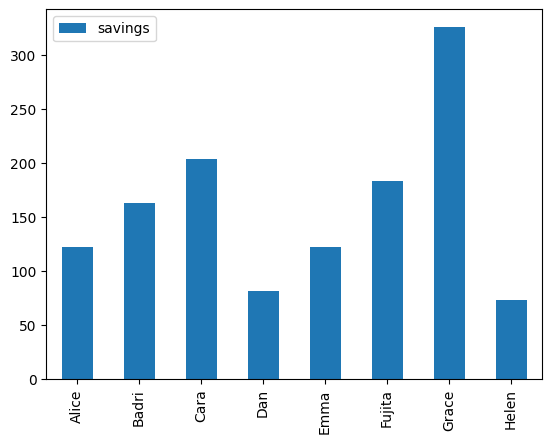

In [5]:
def transport_v3(supply, demand, rates):
    m = pyo.ConcreteModel()

    m.SOURCES = pyo.Set(initialize=rates.columns)
    m.DESTINATIONS = pyo.Set(initialize=rates.index)

    m.x = pyo.Var(m.DESTINATIONS, m.SOURCES, domain=pyo.NonNegativeReals)
    m.rate = pyo.Var()

    @m.Param(m.DESTINATIONS, m.SOURCES)
    def Rates(m, dst, src):
        return rates.loc[dst, src]

    @m.Objective()
    def total_cost(m):
        return sum(
            m.Rates[dst, src] * m.x[dst, src] for dst, src in m.DESTINATIONS * m.SOURCES
        )

    @m.Expression(m.DESTINATIONS)
    def cost_to_destination(m, dst):
        return m.rate * demand[dst]

    @m.Constraint()
    def allocate_costs(m):
        return sum(m.cost_to_destination[dst] for dst in m.DESTINATIONS) == m.total_cost

    @m.Expression(m.DESTINATIONS)
    def shipped_to_destination(m, dst):
        return sum(m.x[dst, src] for src in m.SOURCES)

    @m.Expression(m.SOURCES)
    def shipped_from_source(m, src):
        return sum(m.x[dst, src] for dst in m.DESTINATIONS)

    @m.Constraint(m.SOURCES)
    def supply_constraint(m, src):
        return m.shipped_from_source[src] <= supply[src]

    @m.Constraint(m.DESTINATIONS)
    def demand_constraint(m, dst):
        return m.shipped_to_destination[dst] == demand[dst]

    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    return m


m = transport_v3(supply, demand, rates / 100)
SOLVER.solve(m)
results = round(
    pd.DataFrame(
        {dst: {src: m.x[dst, src]() for src in m.SOURCES} for dst in m.DESTINATIONS}
    ).T,
    1,
)
results["current costs"] = 700 * demand / 8000
results["contract costs"] = round(
    pd.Series({dst: m.cost_to_destination[dst]() for dst in m.DESTINATIONS}), 1
)
results["savings"] = results["current costs"].round(1) - results[
    "contract costs"
].round(1)
results["contract rate"] = 100 * round(results["contract costs"] / demand, 4)
results["marginal cost"] = 100 * pd.Series(
    {dst: m.dual[m.demand_constraint[dst]] for dst in m.DESTINATIONS}
)

print(f"Old delivery costs = ${sum(demand)*700/8000:.2f}")
print(f"New delivery costs = ${m.total_cost():.2f}\n")
display(results)

results.plot(y="savings", kind="bar")
model3_results = results

## Comparing model results

The following charts demonstrate the difference in outcomes for Model 1 and Model 3 (Model 2 was left out as entirely inadequate). The group cost-sharing arrangement produces the same group savings, but distributes the benefits in a manner likely to be more acceptable to the majority of participants.

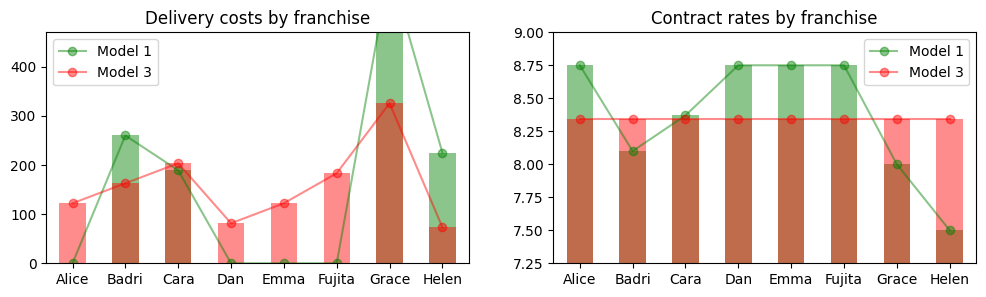

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
alpha = 0.45

model1_results.plot(y=["savings"], kind="bar", ax=ax[0], color="g", alpha=alpha)
model1_results.plot(y="savings", marker="o", ax=ax[0], color="g", alpha=alpha)

model3_results.plot(y="savings", kind="bar", ax=ax[0], color="r", alpha=alpha)
model3_results.plot(y="savings", marker="o", ax=ax[0], color="r", alpha=alpha)
ax[0].legend(["Model 1", "Model 3"])
ax[0].set_ylim(0, 470)
ax[0].set_title("Delivery costs by franchise")

model1_results.plot(y=["contract rate"], kind="bar", ax=ax[1], color="g", alpha=alpha)
model1_results.plot(y="contract rate", marker="o", ax=ax[1], color="g", alpha=alpha)

model3_results.plot(y="contract rate", kind="bar", ax=ax[1], color="r", alpha=alpha)
model3_results.plot(y="contract rate", marker="o", ax=ax[1], color="r", alpha=alpha)
ax[1].set_ylim(7.25, 9)
ax[1].legend(["Model 1", "Model 3"])
ax[1].set_title("Contract rates by franchise")
plt.show()

## Appendix: Reporting solutions

Pyomo models can produce considerable amounts of data that must be summarized and presented for analysis and decision making. In this application, for example, the individual franchise owners receive differing amounts of savings which is certain to result in considerable discussion and possibly negotiation with the franchiser.

The following cells demonstrate techniques for extracting and displaying information generated by a Pyomo model.

### Pyomo `.display()` method

Pyomo provides a default `.display()` method for most Pyomo objects. The default display is often sufficient for model reporting requirements, particularly when initially developing a new application.

In [7]:
# display elements of sets
m.SOURCES.display()
m.DESTINATIONS.display()

SOURCES : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    3 : {'Terminal A', 'Terminal B', 'Current Supplier'}
DESTINATIONS : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    8 : {'Alice', 'Badri', 'Cara', 'Dan', 'Emma', 'Fujita', 'Grace', 'Helen'}


In [8]:
# display elements of an indexed parameter
m.Rates.display()

Rates : Size=24, Index=Rates_index, Domain=Any, Default=None, Mutable=False
    Key                            : Value
     ('Alice', 'Current Supplier') :              0.0875
           ('Alice', 'Terminal A') :               0.083
           ('Alice', 'Terminal B') :               0.102
     ('Badri', 'Current Supplier') :              0.0875
           ('Badri', 'Terminal A') :               0.081
           ('Badri', 'Terminal B') :                0.12
      ('Cara', 'Current Supplier') :              0.0875
            ('Cara', 'Terminal A') :               0.083
            ('Cara', 'Terminal B') :                 1.0
       ('Dan', 'Current Supplier') :              0.0875
             ('Dan', 'Terminal A') : 0.09300000000000001
             ('Dan', 'Terminal B') :                0.08
      ('Emma', 'Current Supplier') :              0.0875
            ('Emma', 'Terminal A') : 0.10099999999999999
            ('Emma', 'Terminal B') :                 0.1
    ('Fujita', 'Current Su

In [9]:
# display elements of Pyomo Expression
m.shipped_to_destination.display()

shipped_to_destination : Size=8
    Key    : Value
     Alice : 30000.0
     Badri : 40000.0
      Cara : 50000.0
       Dan : 20000.0
      Emma : 30000.0
    Fujita : 45000.0
     Grace : 80000.0
     Helen : 18000.0


In [10]:
m.shipped_from_source.display()

shipped_from_source : Size=3
    Key              : Value
    Current Supplier : 133000.0
          Terminal A : 100000.0
          Terminal B :  80000.0


In [11]:
# display Pyomo Objective
m.total_cost.display()

total_cost : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 26113.5


In [12]:
# display indexed Pyomo Constraint
m.supply_constraint.display()
m.demand_constraint.display()

supply_constraint : Size=3
    Key              : Lower : Body     : Upper
    Current Supplier :  None : 133000.0 : 500000.0
          Terminal A :  None : 100000.0 : 100000.0
          Terminal B :  None :  80000.0 :  80000.0
demand_constraint : Size=8
    Key    : Lower   : Body    : Upper
     Alice : 30000.0 : 30000.0 : 30000.0
     Badri : 40000.0 : 40000.0 : 40000.0
      Cara : 50000.0 : 50000.0 : 50000.0
       Dan : 20000.0 : 20000.0 : 20000.0
      Emma : 30000.0 : 30000.0 : 30000.0
    Fujita : 45000.0 : 45000.0 : 45000.0
     Grace : 80000.0 : 80000.0 : 80000.0
     Helen : 18000.0 : 18000.0 : 18000.0


In [13]:
# display Pyomo decision variables
m.x.display()

x : Size=24, Index=x_index
    Key                            : Lower : Value   : Upper : Fixed : Stale : Domain
     ('Alice', 'Current Supplier') :     0 : 30000.0 :  None : False : False : NonNegativeReals
           ('Alice', 'Terminal A') :     0 :     0.0 :  None : False : False : NonNegativeReals
           ('Alice', 'Terminal B') :     0 :     0.0 :  None : False : False : NonNegativeReals
     ('Badri', 'Current Supplier') :     0 :     0.0 :  None : False : False : NonNegativeReals
           ('Badri', 'Terminal A') :     0 : 40000.0 :  None : False : False : NonNegativeReals
           ('Badri', 'Terminal B') :     0 :     0.0 :  None : False : False : NonNegativeReals
      ('Cara', 'Current Supplier') :     0 :  8000.0 :  None : False : False : NonNegativeReals
            ('Cara', 'Terminal A') :     0 : 42000.0 :  None : False : False : NonNegativeReals
            ('Cara', 'Terminal B') :     0 :     0.0 :  None : False : False : NonNegativeReals
       ('Dan', 'Current

### Manually formatted reports

Following solution, the value associated with Pyomo objects are returned by calling the object as a function. The following cell demonstrates the construction of a custom report using Python f-strings and Pyomo methods.

In [14]:
# Objective report
print("\nObjective: cost")
print(f"cost = {m.total_cost()}")

# Constraint reports
print("\nConstraint: supply_constraint")
for src in m.SOURCES:
    print(
        f"{src:12s}  {m.supply_constraint[src]():8.0f}  {m.dual[m.supply_constraint[src]]:8.2f}"
    )

print("\nConstraint: demand_constraint")
for dst in m.DESTINATIONS:
    print(
        f"{dst:12s}  {m.demand_constraint[dst]():8.0f}  {m.dual[m.demand_constraint[dst]]:8.2f}"
    )

# Decision variable reports
print("\nDecision variables: x")
for src in m.SOURCES:
    for dst in m.DESTINATIONS:
        print(f"{src:12s} -> {dst:12s}  {m.x[dst, src]():8.0f}")
    print()


Objective: cost
cost = 26113.5

Constraint: supply_constraint
Terminal A      100000     -0.00
Terminal B       80000     -0.01
Current Supplier    133000     -0.00

Constraint: demand_constraint
Alice            30000      0.09
Badri            40000      0.09
Cara             50000      0.09
Dan              20000      0.09
Emma             30000      0.09
Fujita           45000      0.09
Grace            80000      0.09
Helen            18000      0.08

Decision variables: x
Terminal A   -> Alice                0
Terminal A   -> Badri            40000
Terminal A   -> Cara             42000
Terminal A   -> Dan                  0
Terminal A   -> Emma                 0
Terminal A   -> Fujita               0
Terminal A   -> Grace                0
Terminal A   -> Helen            18000

Terminal B   -> Alice                0
Terminal B   -> Badri                0
Terminal B   -> Cara                 0
Terminal B   -> Dan                  0
Terminal B   -> Emma                 0
Terminal

### Pandas

The Python Pandas library provides a highly flexible framework for data science applications. The next cell demonstrates the translation of Pyomo object values to Pandas DataFrames

,supply,shipped,sensitivity
Terminal A,100000.0,100000.0,-0.0045
Terminal B,80000.0,80000.0,-0.0075
Current Supplier,500000.0,133000.0,-0.0000


,demand,shipped,sensitivity
Alice,30000.0,30000.0,0.0875
Badri,40000.0,40000.0,0.0855
Cara,50000.0,50000.0,0.0875
Dan,20000.0,20000.0,0.0875
Emma,30000.0,30000.0,0.0875
Fujita,45000.0,45000.0,0.0875
Grace,80000.0,80000.0,0.0875
Helen,18000.0,18000.0,0.0795


,Terminal A,Terminal B,Current Supplier
Alice,0.0,0.0,30000.0
Badri,40000.0,0.0,0.0
Cara,42000.0,0.0,8000.0
Dan,0.0,0.0,20000.0
Emma,0.0,0.0,30000.0
Fujita,0.0,0.0,45000.0
Grace,0.0,80000.0,-0.0
Helen,18000.0,0.0,0.0


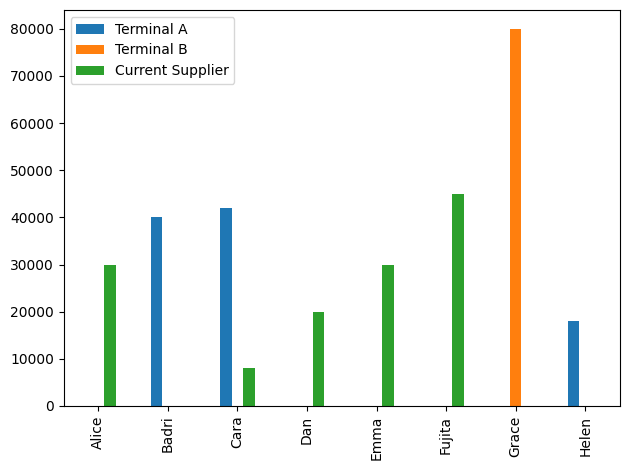

In [15]:
suppliers = pd.DataFrame(
    {
        src: {
            "supply": supply[src],
            "shipped": m.supply_constraint[src](),
            "sensitivity": m.dual[m.supply_constraint[src]],
        }
        for src in m.SOURCES
    }
).T

display(suppliers)

customers = pd.DataFrame(
    {
        dst: {
            "demand": demand[dst],
            "shipped": m.demand_constraint[dst](),
            "sensitivity": m.dual[m.demand_constraint[dst]],
        }
        for dst in m.DESTINATIONS
    }
).T

display(customers)

shipments = pd.DataFrame(
    {dst: {src: m.x[dst, src]() for src in m.SOURCES} for dst in m.DESTINATIONS}
).T
display(shipments)
shipments.plot(kind="bar")
plt.tight_layout()
plt.show()

### Graphviz

The `graphviz` utility is a collection of tools for visually graphs and directed graphs.

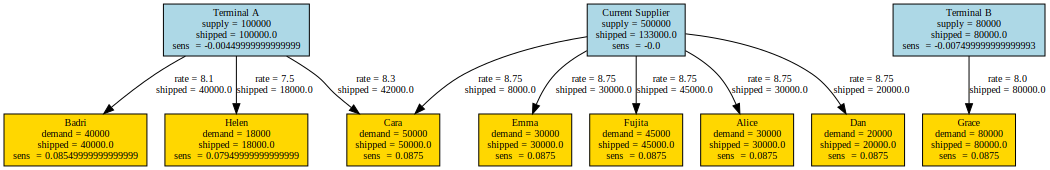

In [16]:
from graphviz import Digraph

dot = Digraph(
    node_attr={"fontsize": "10", "shape": "rectangle", "style": "filled"},
    edge_attr={"fontsize": "10"},
)

for src in m.SOURCES:
    label = (
        f"{src}"
        + f"\nsupply = {supply[src]}"
        + f"\nshipped = {m.supply_constraint[src]()}"
        + f"\nsens  = {m.dual[m.supply_constraint[src]]}"
    )
    dot.node(src, label=label, fillcolor="lightblue")

for dst in m.DESTINATIONS:
    label = (
        f"{dst}"
        + f"\ndemand = {demand[dst]}"
        + f"\nshipped = {m.demand_constraint[dst]()}"
        + f"\nsens  = {m.dual[m.demand_constraint[dst]]}"
    )
    dot.node(dst, label=label, fillcolor="gold")

for src in m.SOURCES:
    for dst in m.DESTINATIONS:
        if m.x[dst, src]() > 0:
            dot.edge(
                src,
                dst,
                f"rate = {rates.loc[dst, src]}\nshipped = {m.x[dst, src]()}",
            )

display(dot)